Conexão com banco de dados feita

Nível de ruído durante 1 segundos: 40.25 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: 24.94 dB
O ambiente simulado está adequado para o sono do paciente
Nível de ruído durante 1 segundos: 40.29 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: 77.79 dB
O ambiente simulado não está adequado para o sono do paciente
Nível de ruído durante 1 segundos: 40.73 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: 92.26 dB
O ambiente simulado não está adequado para o sono do paciente
Nível de ruído durante 1 segundos: 41.10 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: -12.55 dB
O ambiente simulado está adequado para o sono do paciente
Nível de ruído durante 1 segundos: 41.32 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: 45.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Nível de ruído durante 1 segundos: 40.85 dB
O ambiente está adequado para o sono do paciente
Nível de ruído simulado durante 1 segundos: 81.67 dB
O ambiente simulado não está adequado para o sono do paciente


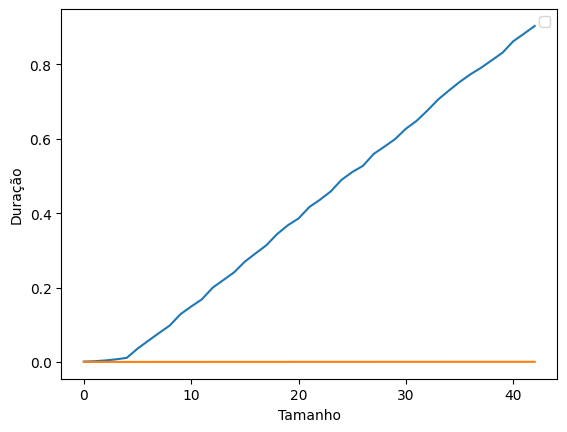

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


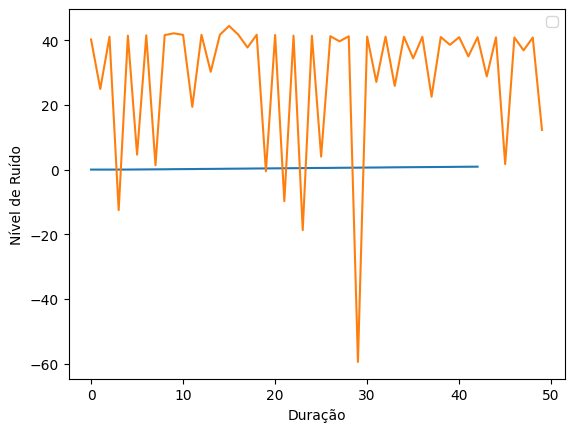

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


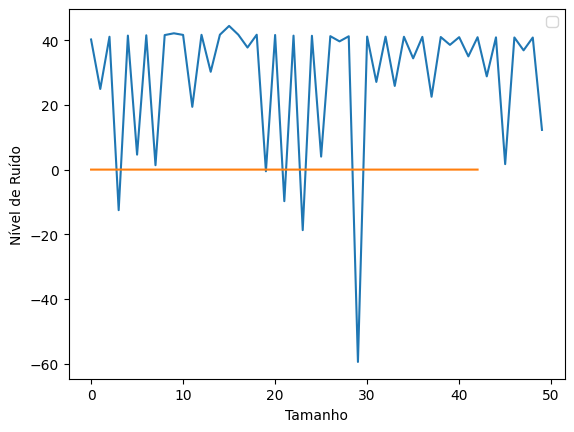

DataError: 1406 (22001): Data too long for column 'ambiente' at row 1

In [6]:
import sys
import pyaudio
import struct
import math
import time
import random
import mysql.connector 
from matplotlib import pyplot as plot
from mysql.connector import errorcode

# Criação de listas
lista_decibel = []
lista_ambiente = []
lista_espaco = []
lista_tempo = []

# Configurações da gravação de áudio
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024

# Inicializa o objeto PyAudio
audio = pyaudio.PyAudio()

# Abre o stream de áudio
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True, frames_per_buffer=CHUNK)

# Define o limiar de ruído máximo permitido (em dB)
MAX_NOISE_LEVEL = 45


def conect_banco():
    try:
        conn = mysql.connector.connect(
            host="localhost", user="root", password="Renato2002", database="ruido", port="3306")
        print("Conexão com banco de dados feita\n")
        return conn
    except mysql.connector.Error as error:
        if error.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database doesn't exist")
        elif error.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("User name or password is wrong")
        else:
            print(error)


def calculate_noise_level(data):

    # Converte os dados do áudio em um array de números inteiros
    data_int = struct.unpack(str(len(data)) + 'B', data)

    # Calcula a energia do sinal
    rms = math.sqrt(sum([(x - 128) ** 2 for x in data_int]) / len(data_int))

    # Calcula o nível de ruído em dB usando a escala A de ponderação de frequência
    decibel = 20 * math.log10(rms)

    return decibel


def medir_nivel_ruido(tempo_medicao):

    conn = conect_banco()
    cursor = conn.cursor()

    inicio_processamento = time.time()

    # Inicializa a variável como verdadeira
    ambiente_adequado = True
    ambiente_simulado = True

    #Variável que vai pro banco
    ambiente = ""
    ambiente_2 = ""

    # Calcula o número de chunks para ler com base no tempo de medição
    num_chunks = int(RATE / CHUNK * tempo_medicao)

    # Inicializa a lista para armazenar os dados de áudio
    data_list = []

    # Lê os dados de áudio do stream
    for i in range(num_chunks):
        data = stream.read(CHUNK)
        data_list.append(data)

        # Concatena os dados de áudio em uma única string
        data_concatenado = b''.join(data_list)

        # Calcula o nível de ruído em dB
        decibel = calculate_noise_level(data_concatenado)
        decibel_simulado = round(random.normalvariate(decibel, 40), 2)

        # Imprime as informações do nível de ruído
        print(
            f"Nível de ruído durante {tempo_medicao} segundos: {decibel:.2f} dB")

        # Verifica se o nível de ruído está acima do limiar máximo permitido
        if decibel > MAX_NOISE_LEVEL:
            print("O ambiente não está adequado para o sono do paciente")
            ambiente_adequado = False
            ambiente = "Não Adequado"
        else:
            print("O ambiente está adequado para o sono do paciente")
            ambiente_adequado = True
            ambiente = "Adequado"

        # Imprime as informações do nível de ruído
            print(
                f"Nível de ruído simulado durante {tempo_medicao} segundos: {decibel_simulado:.2f} dB")

        # Verifica se o nível de ruído está acima do limiar máximo permitido
            if decibel_simulado > MAX_NOISE_LEVEL:
                print("O ambiente simulado não está adequado para o sono do paciente")
                ambiente_simulado = False
                ambiente_2 = "Não Adequado"
            else:
                print("O ambiente simulado está adequado para o sono do paciente")
                ambiente_simulado = True
                ambiente_2 = "Adequado"

                lista_decibel.append(decibel)
                lista_decibel.append(decibel_simulado)
                lista_ambiente.append(ambiente_adequado)
                lista_ambiente.append(ambiente_simulado)


        fim_processamento = time.time() 
        duracao = fim_processamento - inicio_processamento
        espaco = sys.getsizeof(lista_decibel) / (1024 * 1024)

        lista_espaco.append(espaco)
        lista_tempo.append(duracao)

    plot.plot(lista_tempo) 
    plot.plot(lista_espaco) 
    plot.xlabel("Tamanho")
    plot.ylabel("Duração")
    plot.legend()
    plot.show()

    plot.plot(lista_tempo) 
    plot.plot(lista_decibel) 
    plot.ylabel("Nível de Ruído")
    plot.xlabel("Duração")
    plot.legend()
    plot.show()

    plot.plot(lista_decibel) 
    plot.plot(lista_espaco) 
    plot.xlabel("Tamanho")
    plot.ylabel("Nível de Ruído")
    plot.legend()
    plot.show()

    query = f"INSERT INTO nivel_ruido (decibel, ambiente, espaco, duracao) VALUES ('{decibel}', '{ambiente}', '{espaco}', '{duracao}');"
    cursor.execute(query)

    query = f"INSERT INTO nivel_ruido (decibel, ambiente, espaco, duracao) VALUES ('{decibel_simulado}', '{ambiente_2}', '{espaco}', '{duracao}');"
    cursor.execute(query)

    cursor.close()
    conn.commit()   
    conn.close()

    return ambiente_adequado, ambiente_simulado

# Mede o nível de ruído por n segundos
medir_nivel_ruido(1)
